In [146]:
import pandas as pd
import dotenv
import numpy as np
import requests
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
import os
%load_ext dotenv

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [159]:
%dotenv -vo .env

In [156]:
url = ('https://api.eia.gov/v2/electricity/rto/daily-region-sub-ba-data/data/'
       '?frequency=daily'
       '&data[0]=value'
       '&facets[subba][]=ZONJ'
       '&facets[timezone][]=Eastern'
       '&start=2020-01-01'
       '&end=2020-12-31'
       '&sort[0][column]=period'
       '&sort[0][direction]=desc'
       '&offset=0'
       '&length=5000'
       '&api_key=') + os.environ.get('EIA_API_KEY')

In [157]:
data = requests.get(url).json()['response']['data']
data = pd.DataFrame(data)

In [158]:
display(data.head(5))

,period,subba,subba-name,parent,parent-name,timezone,value,value-units
0,2020-12-31,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,125533,megawatthours
1,2020-12-30,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,130838,megawatthours
2,2020-12-29,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,128663,megawatthours
3,2020-12-28,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,126574,megawatthours
4,2020-12-27,ZONJ,New York City,NYIS,New York Independent System Operator,Eastern,122776,megawatthours


In [33]:
demand_daily = data[['period', 'value']].rename(columns={'period': 'date', 'value': 'demand'})
demand_daily['date'] = pd.to_datetime(demand_daily['date'], infer_datetime_format=True)
display(demand_daily.head(5))

,date,demand
0,2020-12-31,125533
1,2020-12-30,130838
2,2020-12-29,128663
3,2020-12-28,126574
4,2020-12-27,122776


In [34]:
display(demand_daily.dtypes)

date      datetime64[ns]
demand             int64
dtype: object

In [0]:
url = ('https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/New%20York%20City%2CUSA/2020-01-01/2020-12-31'
       '?unitGroup=metric'
       '&elements=datetime%2Ctemp'
       '&contentType=json'
       '&include=days%2Cobs%2Cremote%2Cstats'
       '&key=') + os.environ.get('WEATHER_API_KEY')

In [160]:
weather_data = requests.get(url).json()['days']
display(weather_data) # TODO: find alt. source, this one sucks

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [31]:
weather_data = pd.DataFrame(weather_data)
display(weather_data.head(5))

,datetime,temp,normal
0,2020-01-01,3.6,{}
1,2020-01-02,4.8,{}
2,2020-01-03,7.6,{}
3,2020-01-04,8.3,{}
4,2020-01-05,4.6,{}


In [30]:
weather_daily = weather_data[['datetime', 'temp']].rename(columns={'datetime': 'date'})
weather_daily['date'] = pd.to_datetime(weather_daily['date'], infer_datetime_format=True)
display(weather_daily.head(5))

,date,temp
0,2020-01-01,3.6
1,2020-01-02,4.8
2,2020-01-03,7.6
3,2020-01-04,8.3
4,2020-01-05,4.6


In [24]:
display(weather_daily.dtypes)

date    datetime64[ns]
temp           float64
dtype: object

In [29]:
df = pd.merge(weather_daily, demand_daily, how='inner', on='date')
display(df.head(5))

,date,temp,demand
0,2020-01-01,3.6,124168
1,2020-01-02,4.8,135759
2,2020-01-03,7.6,133483
3,2020-01-04,8.3,122924
4,2020-01-05,4.6,123997


In [36]:
df['day'] = df['date'].dt.dayofweek
display(df.head(5)) # 0=mon, ..., sun=6

,date,temp,demand,day
0,2020-01-01,3.6,124168,2
1,2020-01-02,4.8,135759,3
2,2020-01-03,7.6,133483,4
3,2020-01-04,8.3,122924,5
4,2020-01-05,4.6,123997,6


In [37]:
df['month'] = df['date'].dt.month
display(df.head(5)) # 1=jan, ..., dec=12

,date,temp,demand,day,month
0,2020-01-01,3.6,124168,2,1
1,2020-01-02,4.8,135759,3,1
2,2020-01-03,7.6,133483,4,1
3,2020-01-04,8.3,122924,5,1
4,2020-01-05,4.6,123997,6,1


In [40]:
seed = np.random.RandomState(65)

In [41]:
df_num = df.drop(columns=['date'])

In [125]:
label = 'demand'
X = df_num.drop(columns=[label])
y = df_num[label]
display(X.head(5))
display(y.head(5))

,temp,day,month
0,3.6,2,1
1,4.8,3,1
2,7.6,4,1
3,8.3,5,1
4,4.6,6,1


0    124168
1    135759
2    133483
3    122924
4    123997
Name: demand, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
display(X_train.head(5))
display(y_train.head(5))
display(X_test.head(5))
display(y_test.head(5))

,temp,day,month
24,6.6,5,1
313,17.5,0,11
360,-1.4,5,12
10,14.7,5,1
199,28.3,5,7


24     126400
313    119150
360    123588
10     119972
199    164104
Name: demand, dtype: int64

,temp,day,month
120,12.6,3,4
239,26.2,3,8
165,18.8,6,6
111,10.2,1,4
100,7.1,4,4


120    109556
239    169235
165    109258
111    107374
100    108499
Name: demand, dtype: int64

In [98]:
kf = RepeatedKFold(n_splits=5, random_state=seed)

In [99]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=seed) # default metric
params = {
    'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
    'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]
}

In [100]:
gs_xgb = RandomizedSearchCV(xgb,
                            random_state=seed,
                            param_distributions=params,
                            cv=kf,
                            verbose=3,
                            n_jobs=-1)

In [101]:
gs_xgb.fit(X_train, y_train)

Fitting 50 folds for each of 10 candidates, totalling 500 fits


C:\Users\Remo\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


RandomizedSearchCV(cv=RepeatedKFold(n_repeats=10, n_splits=5,
       random_state=RandomState(MT19937) at 0x1974F220840),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          enable_categorical=False, gamma=None,
                                          gpu_id=None, importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,
                                          max_...
                                          scale_pos_weight=None, subsample=None,
                                          tree_method=None,
                                          validate_parameters=None,
                                          verbosity=None),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7]},
                   random_state=RandomState(MT19937) at 0x1974F220840,
                   verbose=3)

In [102]:
display(gs_xgb.best_params_)
display(gs_xgb.best_score_)

{'min_child_weight': 5,
 'max_depth': 4,
 'learning_rate': 0.25,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

0.9368638083638717

In [103]:
# get best model
model = gs_xgb.best_estimator_

In [106]:
# get predictions for test set to get a performance estimate for unseen data
# best model is already re-trained on whole training data! (default for refit=True)
y_pred = model.predict(X_test)
err = mean_absolute_error(y_test, y_pred)
display(err) # MWh

4538.084459459459

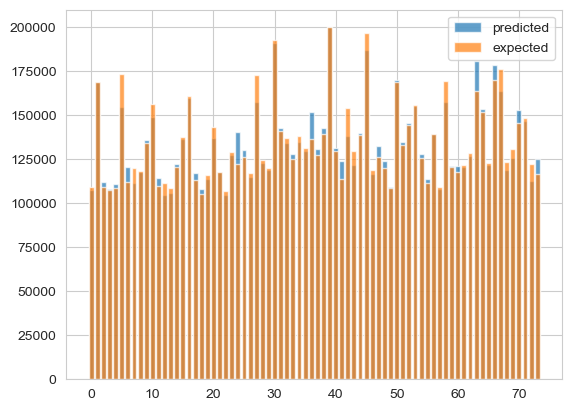

In [124]:
pyplot.bar(x=np.arange(len(y_pred)), height=y_pred, label='predicted', alpha=0.7)
pyplot.bar(x=np.arange(len(y_pred)), height=y_test.to_numpy(), label='expected', alpha=0.7)
pyplot.legend()
pyplot.show() # this representation doesn't make a lot of sense 🤷‍♂️